In [1]:
!pip install pypianoroll

In [2]:
!pip install pygame

In [3]:
!pip install pretty_midi

In [19]:
import numpy as np
import pypianoroll
from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt
import pretty_midi
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import pygame
import os
import pickle
import subprocess

%matplotlib inline

import matplotlib

import seaborn as sns


In [5]:
# Parse a MIDI file to a `pypianoroll.Multitrack` instance

multitrack = Multitrack('./data/rock.mid')
for idx, track in enumerate(multitrack.tracks):
    pianoroll = track.pianoroll


#print (multitrack.beat_resolution,)
num_track = len(multitrack.tracks)
downbeats = multitrack.get_downbeat_steps()
#print (downbeats,num_track)

In [6]:
# drum had only 47 keyname.
# For details https://www.midi.org/specifications/item/gm-level-1-sound-set

pianoroll_drum = np.asarray([ pianoroll[i][35:82] for i in range(0,pianoroll.shape[0]) ])
print (pianoroll_drum.shape)



(5664, 47)


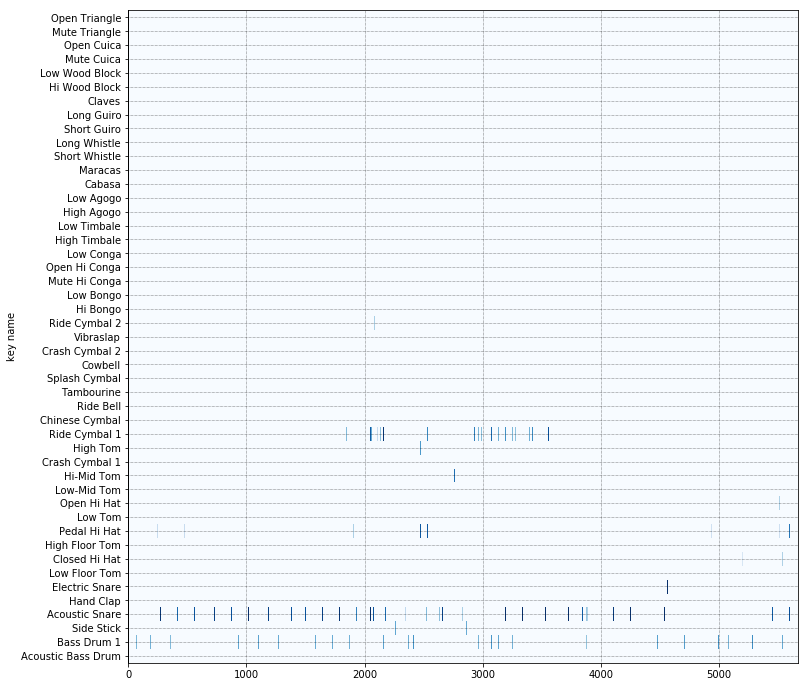

In [7]:
def plot_drum(q):
    fig, ax = plt.subplots(figsize=(12,12))
    axs = [ax]
    ax.set_yticks(np.arange(0,47))
    drum_label = [pretty_midi.note_number_to_drum_name(i) for i in range(128)]
    ax.set_yticklabels( drum_label[35:82])
    ax.set_ylabel("key name")
    ax.grid(
                axis="both", color="k", linestyle=":", linewidth=0.5
            )
    for step in downbeats:
        ax.axvline(x=step, color="k", linewidth=1)

    to_plot = q.T
    ax.imshow(
                to_plot,
                cmap='Blues',
                aspect="auto",
                vmin=0,
                vmax=127,
                origin="lower",
                interpolation="none",
            )


    fig.show()
    
plot_drum(pianoroll_drum)
    

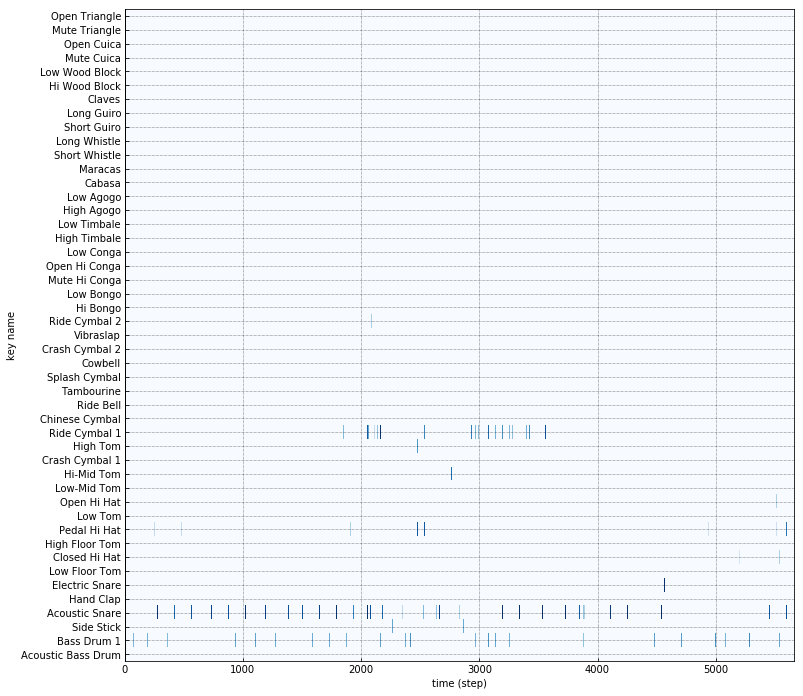

In [8]:
#fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12,12))
axs = [ax]
cmaps = ("Blues", "Greens")
pypianoroll.plot_pianoroll(
                axs[0],
                pianoroll_drum,
                True,
                24,
                downbeats,
                preset="default",
                cmap=cmaps[0 % len(cmaps)],
                xtick="step",
                            ytick="pitch", 
                            yticklabel="name"
            )

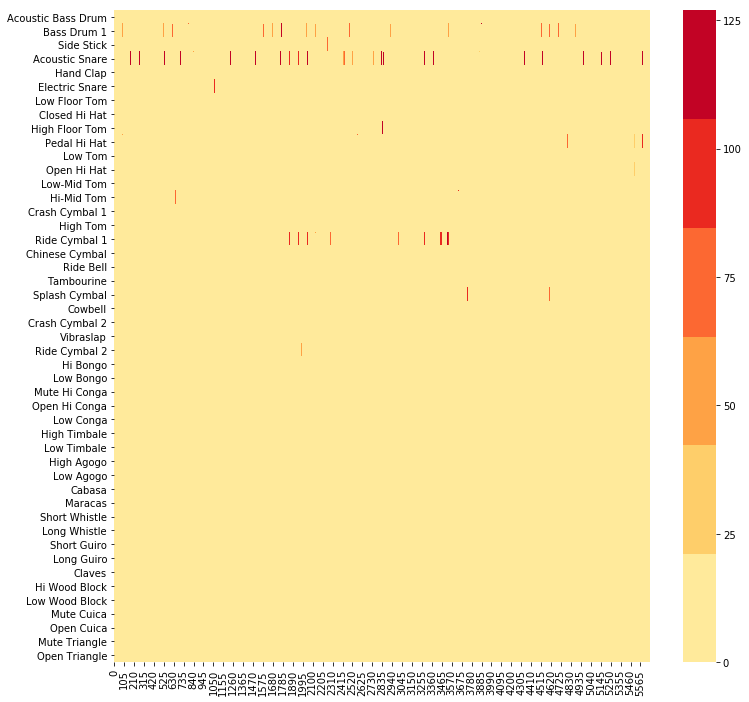

In [14]:
plt.subplots(figsize=(12,12))
drum_label = [pretty_midi.note_number_to_drum_name(i) for i in range(128)]

sns.heatmap(pianoroll_drum.T, cmap = sns.color_palette("YlOrRd"), yticklabels=drum_label[35:82])


In [9]:
pypianoroll.save_animation(
    'img/ani.gif',
    pianoroll_drum,
    100,hop=100,
    fps=12)

t:   8%|▊         | 4/48 [00:00<00:01, 39.92it/s, now=None]

MoviePy - Building file img/ani.gif with imageio.


![Annimation of drum](img/ani.gif)

In [ ]:
# follow installation of midi2ly
# http://manpages.ubuntu.com/manpages/trusty/man1/midi2ly.1.html
# follow installation of LilyPond
# https://zoomadmin.com/HowToInstall/UbuntuPackage/lilypond
# http://lilypond.org/doc/v2.19/Documentation/topdocs/INSTALL.html

In [24]:

def midi2ly(midifile,output):
    c = 'midi2ly -x --allow-tuplet=8*1/3 "{0}" -o "{1}"'.format(midifile, output)
    print ('Executing: ' + c)
    p = subprocess.Popen(c, shell=True).wait()
    return True

In [29]:
def to_pdf(title):
    """ Requires LilyPond added to PATH."""

    c = 'lilypond -fpdf -o "{0}" "{1}.ly"'.format(title, title)
    print ('Executing: ' + c)
    p = subprocess.Popen(c, shell=True).wait()
    os.remove(title + '.ly')
    return True

In [31]:
midi2ly("./data/rock.mid", "./data/rock.ly") 

Executing: midi2ly -x --allow-tuplet=8*1/3 "./data/rock.mid" -o "./data/rock.ly"


True

In [30]:
to_pdf("./data/rock")

Executing: lilypond -fpdf -o "./data/rock" "./data/rock.ly"


True

In [32]:
#Viewing music - via https://github.com/cuthbertLab/music21/issues/306 ?
from IPython.core.display import display, HTML, Javascript
import json, random
def showScore(score):
    xml = open(score.write('musicxml')).read()
    showMusicXML(xml)
    
def showMusicXML(xml):
    DIV_ID = "OSMD-div-"+str(random.randint(0,1000000))
    #print("DIV_ID", DIV_ID)
    msg='loading OpenSheetMusicDisplay'
    msg=''
    display(HTML('<div id="'+DIV_ID+'">{}</div>'.format(msg)))
    
    #print('xml length:', len(xml))

    script = """
    console.log("loadOSMD()");
    function loadOSMD() { 
        return new Promise(function(resolve, reject){

            if (window.opensheetmusicdisplay) {
                console.log("already loaded")
                return resolve(window.opensheetmusicdisplay)
            }
            console.log("loading osmd for the first time")
            // OSMD script has a 'define' call which conflicts with requirejs
            var _define = window.define // save the define object 
            window.define = undefined // now the loaded script will ignore requirejs
            var s = document.createElement( 'script' );
            s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.3.1/build/opensheetmusicdisplay.min.js" );
            //s.setAttribute( 'src', "/custom/opensheetmusicdisplay.js" );
            s.onload=function(){
                window.define = _define
                console.log("loaded OSMD for the first time",opensheetmusicdisplay)
                resolve(opensheetmusicdisplay);
            };
            document.body.appendChild( s ); // browser will try to load the new script tag
        }) 
    }
    loadOSMD().then((OSMD)=>{
        console.log("loaded OSMD",OSMD)
        var div_id = "{{DIV_ID}}";
            console.log(div_id)
        window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id);
        openSheetMusicDisplay
            .load({{data}})
            .then(
              function() {
                console.log("rendering data")
                openSheetMusicDisplay.render();
              }
            );
    })
    """.replace('{{DIV_ID}}',DIV_ID).replace('{{data}}',json.dumps(xml))
    display(Javascript(script))
    return DIV_ID


In [36]:
from music21 import converter
melody = converter.parse("data/rock.mid")
melody.show('midi')

showScore(melody)

<IPython.core.display.Javascript object>

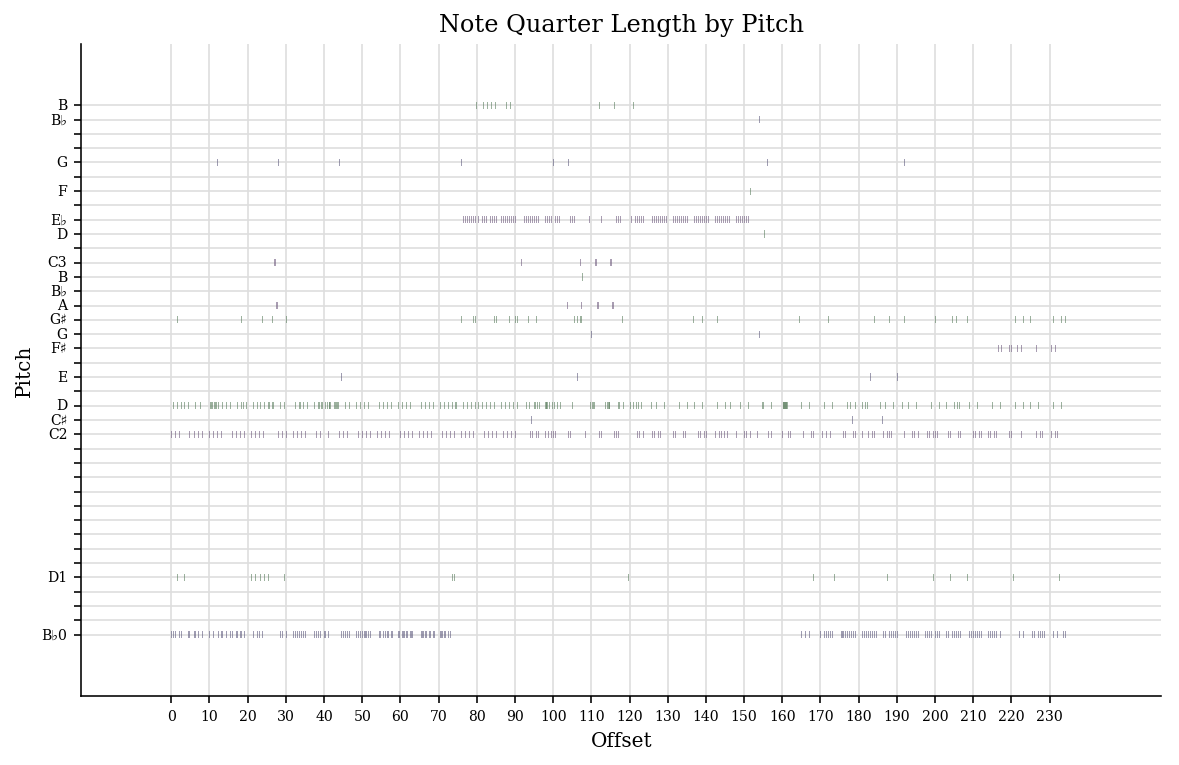

In [37]:
melody.plot()

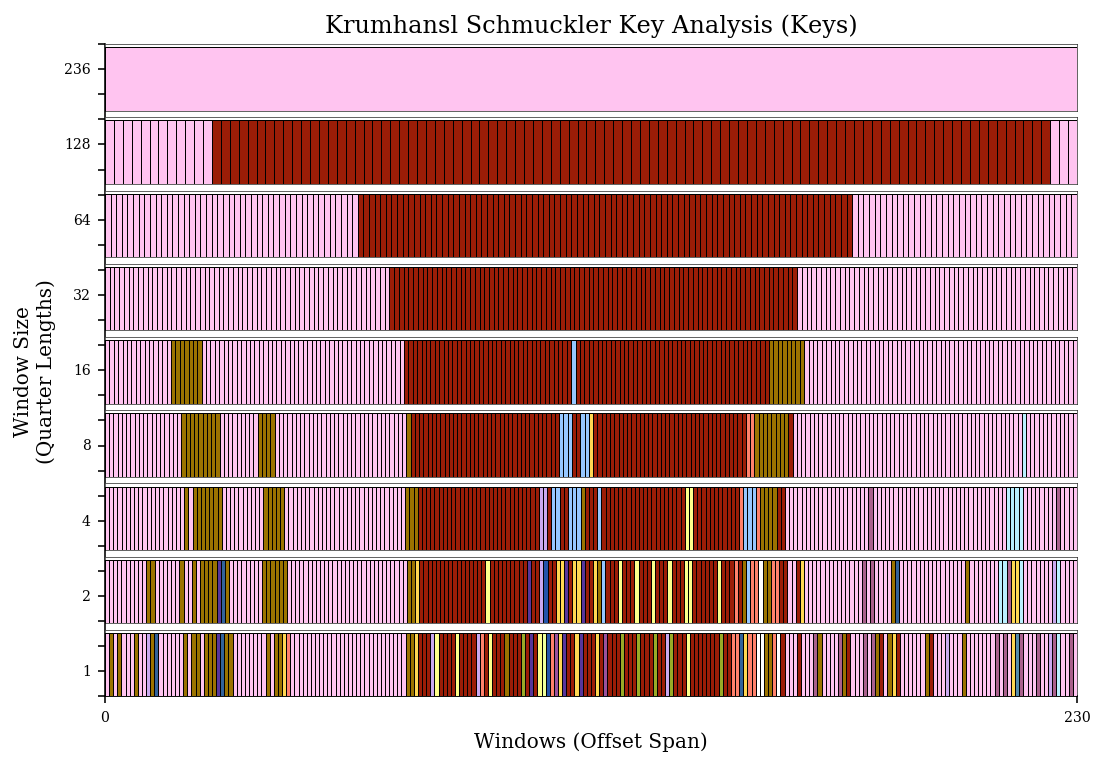

In [38]:
#https://ccrma.stanford.edu/~craig/papers/01/icmc01-harmony-2up.pdf
melody.plot('key')

In [40]:
melody.measures(10, 15).analyze('key')

<music21.key.Key of g minor>

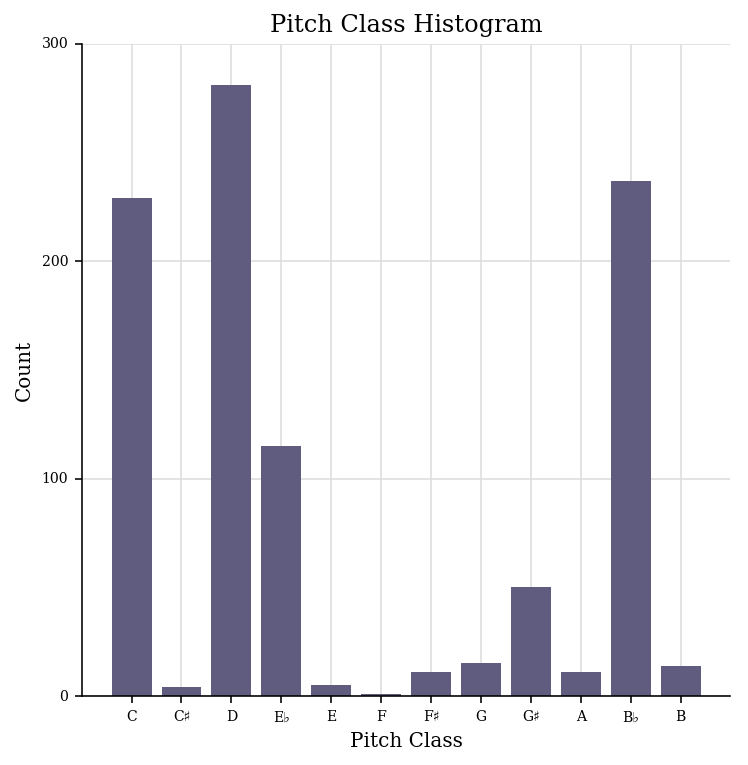

In [41]:
melody.plot('histogram', 'pitchClass')